In [100]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage.morphology import opening, closing, disk

In [101]:
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

**Exercise 1**

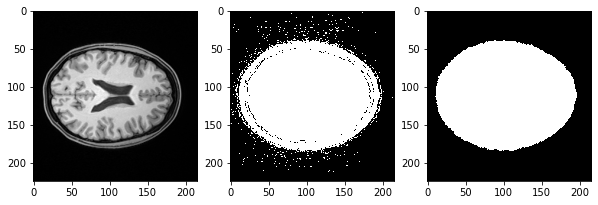

In [102]:
mask_init = ImgT1 > 10
mask = opening(mask_init, disk(2))
mask = closing(mask, disk(3))

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask, cmap = 'gray', interpolation = 'none')
plt.show()

In [103]:
def my_show_1D_histogram(img, mask, img_name, axs):
    axs[0].imshow(img, cmap = 'gray')
    axs[0].set_title(img_name)
    axs[0].set_axis_off()

    intensities = img[mask]
    axs[1].hist(intensities, bins = 100)
    axs[1].set_title(f'1D Histogram {img_name}')
    axs[1].set_xlabel('Intensities')
    axs[1].set_ylabel('Frequency')

    return intensities

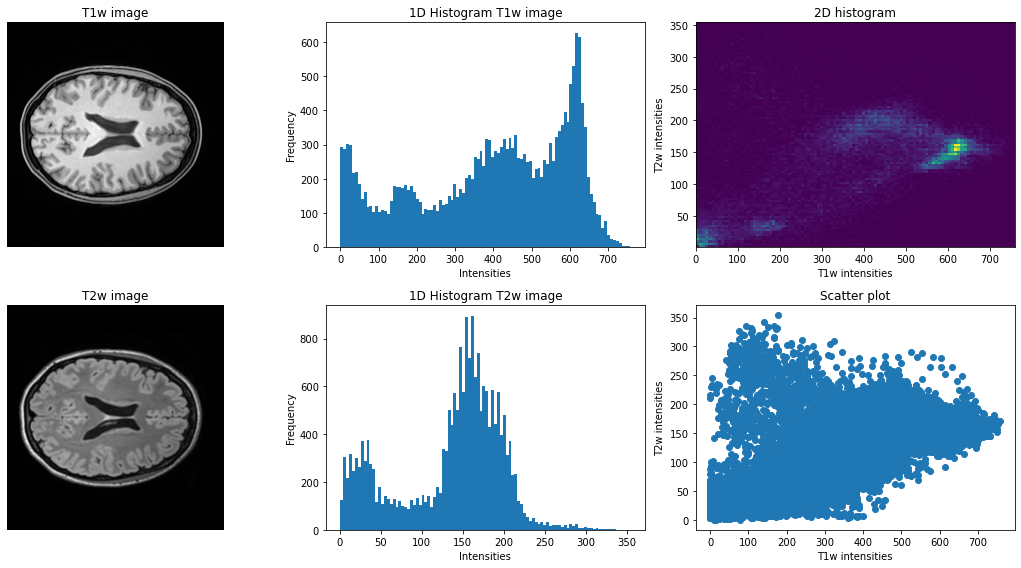

In [104]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
T1_intensities = my_show_1D_histogram(ImgT1, mask, 'T1w image', axs[0, 0:2])
T2_intensities = my_show_1D_histogram(ImgT2, mask, 'T2w image', axs[1, 0:2])
axs[0,2].hist2d(T1_intensities, T2_intensities, bins = 100)
axs[0,2].set_xlabel('T1w intensities')
axs[0,2].set_ylabel('T2w intensities')
axs[0,2].set_title('2D histogram')

axs[1,2].scatter(T1_intensities, T2_intensities)
axs[1,2].set_xlabel('T1w intensities')
axs[1,2].set_ylabel('T2w intensities')
axs[1,2].set_title('Scatter plot')
plt.tight_layout()
plt.show()
plt.show()

Q1: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histograms?

T1w = 500
T2w = 160

Q2: Can the GM and WM intensity classes be observed in the 2D histogram and scatter plot?

**Exercise 2**

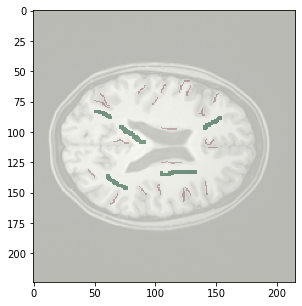

In [105]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(ROI_GM, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(ROI_WM, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()

**Exercise 3**

In [106]:
# This is not necessary with the coding style followed in this solution.
qC1 = np.argwhere(ROI_WM) # Shape (399, 2) 
qC2 = np.argwhere(ROI_GM) # (280, 2)

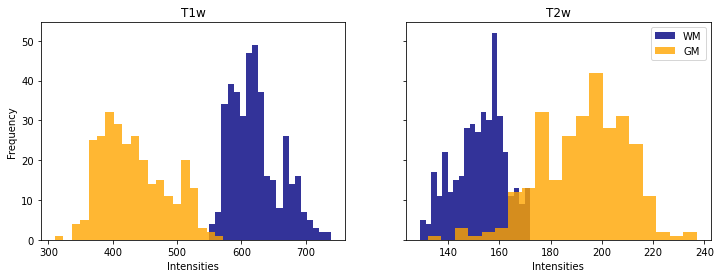

In [107]:
trainWM_T1 = ImgT1[ROI_WM] # trainWM_T1 = ImgT1[qC1[:,0], qC1[:,1]]
trainGM_T1 = ImgT1[ROI_GM] # trainGM_T1 = ImgT1[qC2[:,0], qC2[:,1]]

trainWM_T2 = ImgT2[ROI_WM] # trainWM_T2 = ImgT2[qC1[:,0], qC1[:,1]]
trainGM_T2 = ImgT2[ROI_GM] # trainGM_T2 = ImgT2[qC2[:,0], qC2[:,1]]

fig, axs = plt.subplots(1, 2, figsize = (12, 4), sharex = False, sharey = True)
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')
plt.legend()
plt.show()

**Exercise 4**

In [108]:
# Feature matrix, X -> Shape: (n_samples, n_features)
X1 = np.c_[ImgT1[ROI_WM], ImgT2[ROI_WM]] 
X2 = np.c_[ImgT1[ROI_GM], ImgT2[ROI_GM]]
X = np.r_[X1, X2]
# Label vector, T -> Shape: (n_samples)
n_pixels = X.shape[0]
n_wm_pixels = X1.shape[0]
T = np.zeros((n_pixels, 1))
T[n_wm_pixels:] = 1


**Exercise 5**

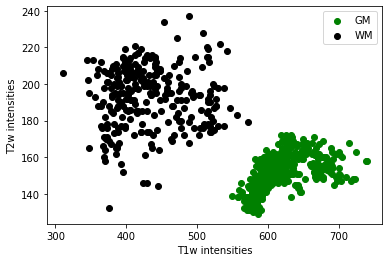

In [109]:
fig, ax = plt.subplots(1,1)
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'GM')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'WM')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
plt.legend()
plt.show()

**Exercise 6**

In [110]:
from LDA import LDA
W = LDA(X,T)
print(W)

[[-138.11536977    0.27566672    0.68044071]
 [-131.32787698    0.15900268    0.99568003]]


**Exercise 7**

In [111]:
Xall= np.c_[ImgT1.ravel(), ImgT2.ravel()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

**Exercise 8**

In [112]:
PosteriorProb = np.clip((np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis]), 0, 1)

**Exercise 9**

In [113]:
posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 >= 0.5
mask_GM = posteriorC2 > 0.5

ValueError: NumPy boolean array indexing assignment cannot assign 48384 input values to the 20659 output values where the mask is true

NameError: name 'mask_WM' is not defined

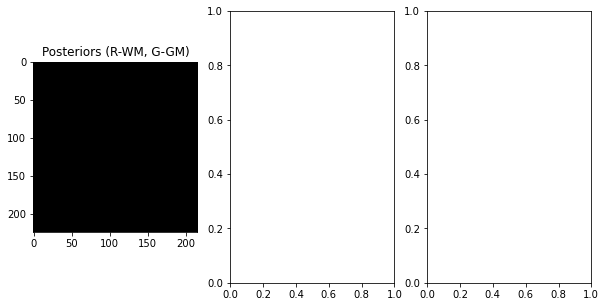

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

**Finished in the solved exericses, for me is not working**